In [39]:
import meva
from meva.lib.spin import get_pretrained_hmr
import mmcv 
import torch
from meva.utils import image_utils
from utils import imshownp
from skimage.transform import resize
import numpy as np
import data
from utils import makedirs_ifno
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

In [43]:
from importlib import reload
reload(data)

<module 'data' from '/home/tormod/Documents/APEC/data.py'>

In [44]:
out_folder = '/home/tormod/ucph-erda-home/hmr_features'
c = data.ClimbingDataset('all', 
                         feat_folder=None, #out_folder,
                         seq_len=1)

In [45]:
c.get(4)

{'raw_imgs': array([[[[226, 215, 206],
          [226, 215, 206],
          [226, 215, 206],
          ...,
          [159, 164, 170],
          [161, 166, 172],
          [160, 165, 171]],
 
         [[226, 215, 206],
          [226, 215, 206],
          [226, 215, 206],
          ...,
          [156, 161, 167],
          [158, 163, 169],
          [158, 163, 169]],
 
         [[226, 215, 206],
          [226, 215, 206],
          [226, 215, 206],
          ...,
          [147, 152, 158],
          [149, 154, 160],
          [146, 151, 157]],
 
         ...,
 
         [[ 37,  31,  26],
          [ 37,  31,  26],
          [ 37,  31,  26],
          ...,
          [162, 172, 171],
          [161, 171, 170],
          [162, 172, 171]],
 
         [[ 31,  25,  20],
          [ 31,  25,  20],
          [ 31,  25,  20],
          ...,
          [169, 179, 178],
          [172, 182, 181],
          [162, 172, 171]],
 
         [[ 26,  20,  15],
          [ 26,  20,  15],
          [ 26,  2

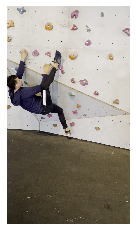

In [31]:
imshownp(c.vids[data.stripped_names.index('IMG_2315')][80], bgr=True, savename='heel_hook.png')

In [3]:
hmr = get_pretrained_hmr()

====> Loading pre trained: data/meva_data/spin_model_checkpoint.pth.tar


In [4]:
hmr.eval()
d = c.get(0)
imgs = d['norm_imgs']
imgs = imgs[:1]
imgs = imgs.float().to('cuda')
feat, out = hmr(imgs, return_features=True)

In [5]:
out[0].keys()

dict_keys(['theta', 'verts', 'kp_2d', 'kp_3d'])

In [6]:
d.keys()

dict_keys(['raw_imgs', 'norm_imgs', 'features', 'climb_labels', 'kp_2d', 'vid_idx', 'frames', 'bboxes', 'trans', 'inv_trans'])

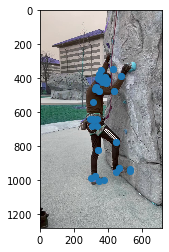

In [7]:
img = d['raw_imgs'][0]
norm_img = d['norm_imgs'][0]
imshownp(img)
kp_2d = out[0]['kp_2d'].cpu().detach().numpy()[0]
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
#kp_3d = out[0]['kp_3d'].cpu().detach().numpy()[0]
kp_2d = image_utils.trans_points2d(kp_2d, d['inv_trans'])
plt.scatter(kp_2d[:,0], kp_2d[:,1])

In [8]:
import mesh
verts = out[0]['verts'][0].cpu().detach().numpy()
theta = out[0]['theta'][0].cpu().detach().numpy()
pred_cam = theta[:3]
imshownp(mesh.render_pred_mesh(img, d['bboxes'][:1], verts, pred_cam))

ValueError: not enough values to unpack (expected 2, got 1)

In [9]:
makedirs_ifno([f'{out_folder}/{n}/' for n in c.stripped_names])

for i in trange(len(c)):
    seq = c.get(i)
    imgs = seq['norm_imgs']
    vid_name = c.stripped_names[seq['vid_idx']]
    frames = seq['frames']
    frames = np.arange(frames.start, frames.stop)
    for f, img in zip(frames, imgs):
        img = img.float().unsqueeze(0).to('cuda')
        feat, out = hmr(img, return_features=True)
        feat = feat.cpu().detach().numpy()[0]
        out = out[0]
        out = dict([(k, out[k].cpu().detach().numpy()) for k in out])
        out['features'] = feat
        np.save(f'{out_folder}/{vid_name}/{f:06d}', out)
        

In [ ]:
res = np.load(f'{out_folder}/{c.stripped_names[0]}/000001.npy', allow_pickle=True)

In [ ]:
res.item()['features']